In [132]:
# VARIATIONAL AUTO-ENCODER
# Fits a VAE to the data and save the fitted functions
# Same as vae_M1 but
# This version of vae estimates the residual variance of the observations.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from pathlib import Path
import scipy.stats as scs
import argparse



In [133]:
# Create a parser for the file
# parser = argparse.ArgumentParser()
# parser.add_argument("dir", help="the name of the directory")
# args = parser.parse_args()


# Replace this by the above in the script
class myparser():
    def __init__(self, dir):
        self.dir = dir


args = myparser("../simulations/M2_q5/data_p50")

In [134]:
# ## Create the sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# ## Create the variational autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, K, known_variance, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.K = K
        self.known_variance=known_variance
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = 0.5 * tf.reduce_mean(tf.reduce_sum((data - reconstruction)**2 / self.known_variance + tf.math.log(self.known_variance) + tf.math.log(2. * np.pi), axis=1))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def plot_model(self, input_shape, to_file=Path("tmp/model.png")):
        # create the full model
        encoder_inputs = keras.Input(shape=input_shape)
        z_mean, z_logvar, z = self.encoder(encoder_inputs)
        reconstruction = self.decoder(z)

        full_model = keras.Model(encoder_inputs, reconstruction)

        tf.keras.utils.plot_model(full_model, to_file=to_file, show_shapes=True)

        return None



def generate_vae(input_shape, latent_dim, K=5, known_variance=1.):
    # ## Create the encoder network
    """ Create the encoder network; K is the dimension of the last layer. A small number helps not to overfit. This is determined by n, see the paper for references."""

    encoder_inputs = keras.Input(shape=input_shape)

    x = layers.Flatten()(encoder_inputs)
    x = layers.Dense(100, activation="tanh")(x)

    z_mean = layers.Dense(100, activation="tanh")(x)
    z_mean = layers.Dense(50, activation="tanh")(z_mean)
    z_mean = layers.Dense(latent_dim, name="z_mean", activation="linear")(z_mean)

    z_log_var = layers.Dense(100, activation="tanh")(x)
    z_log_var = layers.Dense(50, activation="tanh")(z_log_var)
    z_log_var = layers.Dense(latent_dim, name="z_log_var", activation="linear")(z_log_var)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # ## Create the Decoder network
    # For each of the latent variables, we create a NN. The last layer takes their sum.
    x_output_list = []
    latent_inputs = keras.Input(shape=(latent_dim,))

    # now split into num_latent data
    latent_split = layers.Lambda(lambda layer: tf.split(layer, latent_dim, axis=-1), name=f'Split_into_{latent_dim}_layers')(latent_inputs)

    assert len(latent_split) == latent_dim
    
    for i in range(latent_dim):
        x = layers.Dense(100, activation="tanh")(latent_split[i])
        x_output = layers.Dense(100, activation="tanh")(x)
        x_output = layers.Dense(50, activation="tanh")(x_output)
        x_output = layers.Dense(K, activation="tanh")(x_output)
        x_output = layers.Dense(input_shape[0], activation="linear")(x_output)
        x_output = layers.Reshape(input_shape)(x_output)
        x_output_list.append(x_output)

    x_output = layers.Add(name="list_of_g")(x_output_list)
    decoder = keras.Model(latent_inputs, x_output, name="decoder")

    vae = VAE(encoder, decoder, K=K, known_variance=known_variance)

    return(vae)


In [135]:
def preprocessing(path):
    # we pre-train the vae by randomizing the column orders
    data = pd.read_csv(path)
    data = np.array(data, dtype='float32')
    data = data[:,np.random.choice(data.shape[1], data.shape[1], replace=False)]
    data = np.expand_dims(data, axis=-1)
    return data


In [136]:
def vae_fit(data, K=5, known_variance=1., latent_dim=5):
    callback = tf.keras.callbacks.EarlyStopping(monitor='total_loss', patience=50)
    vae = generate_vae(input_shape=data.shape[1:], latent_dim=latent_dim, K=K, known_variance=known_variance)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
    vae.fit(data, epochs=1000, callbacks=[callback])

    # We now create a model to give as output the `latent_dim` functions evaluated for a given $z$.

    intermediate_layer_model = keras.Model(inputs = vae.decoder.input,
                                        outputs = vae.decoder.get_layer("list_of_g").input)

    return(vae, intermediate_layer_model)



## Get the estimated decoder functions

In [137]:
def save_output(data, vae, intermediate_model, file):

    # save g
    dist = scs.norm(0,1)
    prob = np.arange(1,201)/201.
    z = dist.ppf(prob)
    z = np.repeat(z[:, np.newaxis], num_latent, axis=1)

    y_list = intermediate_model.predict(z)

    for k in range(len(y_list)):
        y = y_list[k].squeeze()
        zy = np.concatenate((z[:,0, np.newaxis], y), axis=1)
        df = pd.DataFrame(
            data=zy, 
            columns=["z"] + ["g"+str(i+1) for i in range(y.shape[1])])

        # create folder
        outdir = PATH_TO_FIT/f"g{(k+1)}"
        outdir.mkdir(parents=True, exist_ok=True)

        # save
        df.to_csv(outdir/file, index=False)

    # save z

    z, _, _ = vae.encoder(data)
    df = pd.DataFrame(
        data = z,
        columns = ["z" + str(i+1) for i in range(z.shape[1])]
    )
    # create folder
    outdir = PATH_TO_FIT/"z"
    outdir.mkdir(parents=True, exist_ok=True)

    # save
    df.to_csv(outdir/file, index=False)
    

In [138]:
num_latent = 5

PATH_TO_DATA = Path("data/q5/x")
PATH_TO_FIT = Path("data/q5/vae_fit")
file = "M2_q5_p100_1.csv"
data = preprocessing(PATH_TO_DATA/file)


In [139]:
vae = generate_vae(input_shape=data.shape[1:], latent_dim=num_latent, K=5, known_variance=1.)

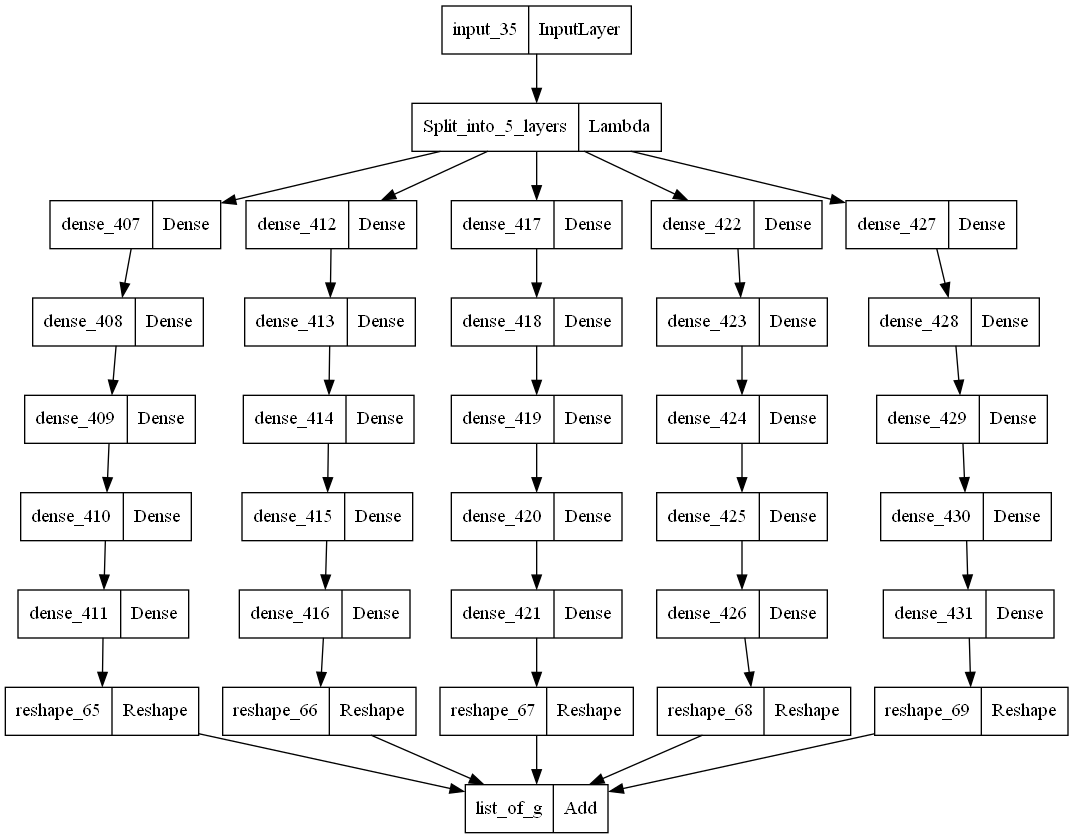

In [157]:
tf.keras.utils.plot_model(vae.decoder)

In [158]:
vae.decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 Split_into_5_layers (Lambda)   [(None, 1),          0           ['input_35[0][0]']               
                                 (None, 1),                                                       
                                 (None, 1),                                                       
                                 (None, 1),                                                       
                                 (None, 1)]                                                       
                                                                                            

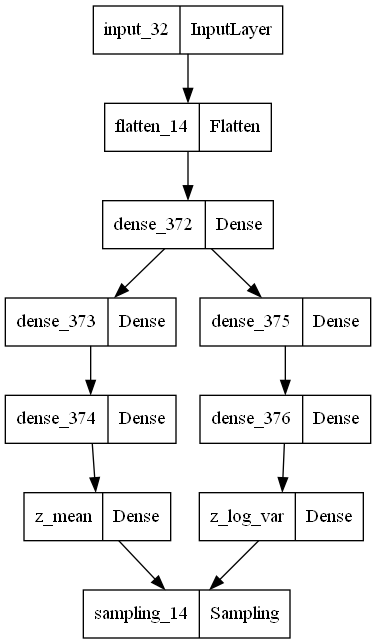

In [142]:
tf.keras.utils.plot_model(vae.encoder)

In [154]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 flatten_15 (Flatten)           (None, 100)          0           ['input_34[0][0]']               
                                                                                                  
 dense_402 (Dense)              (None, 100)          10100       ['flatten_15[0][0]']             
                                                                                                  
 dense_403 (Dense)              (None, 100)          10100       ['dense_402[0][0]']              
                                                                                            

In [144]:
vae, intermediate_model = vae_fit(data,  K=5, known_variance=1., latent_dim=num_latent)

Epoch 1/1000
7/7 [==============================] - 15s 8ms/step - total_loss: 317.1170 - reconstruction_loss: 315.5192 - kl_loss: 1.5978
Epoch 2/1000
7/7 [==============================] - 0s 9ms/step - total_loss: 306.7812 - reconstruction_loss: 304.9752 - kl_loss: 1.8059
Epoch 3/1000
7/7 [==============================] - 0s 10ms/step - total_loss: 300.2894 - reconstruction_loss: 298.4231 - kl_loss: 1.8663
Epoch 4/1000
7/7 [==============================] - 0s 9ms/step - total_loss: 294.0356 - reconstruction_loss: 291.9947 - kl_loss: 2.0408
Epoch 5/1000
7/7 [==============================] - 0s 8ms/step - total_loss: 290.3656 - reconstruction_loss: 287.9225 - kl_loss: 2.4432
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - total_loss: 281.9683 - reconstruction_loss: 279.5055 - kl_loss: 2.4629
Epoch 7/1000
7/7 [==============================] - 0s 8ms/step - total_loss: 277.3113 - reconstruction_loss: 274.9732 - kl_loss: 2.3381
Epoch 8/1000
7/7 [=====================

7/7 [==============================] - 0s 3ms/step


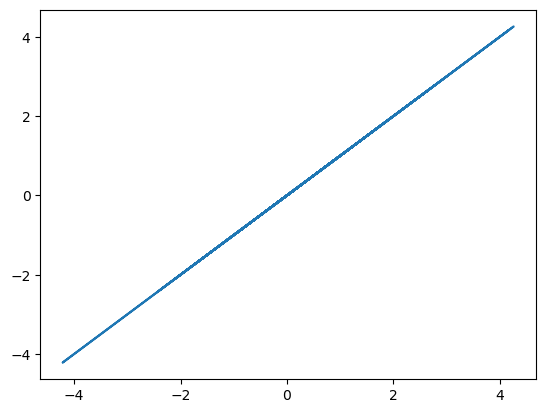

In [156]:
save_output(data, vae, intermediate_model, file)